In [ ]:
!pip install segmentation-models

In [2]:
import ImageSynthetique as imsy
from ImageSynthetique import timing
import Dataset as ds
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import gc
import skimage
from tensorflow import keras
from skimage.util import view_as_windows
import tensorflow as tf
import segmentation_models as sm
import matplotlib.patches as patches
img_shape = (32, 32)

Segmentation Models: using `tf.keras` framework.


In [38]:
height, width = (300, 640)
train = imsy.Image(height, width, noise_lvl=0.12)
train.add_ladder(starting_pt=[24 * 4, 25],
                spacing=7, length=12, l_var=1, lines=32)
train.clip()

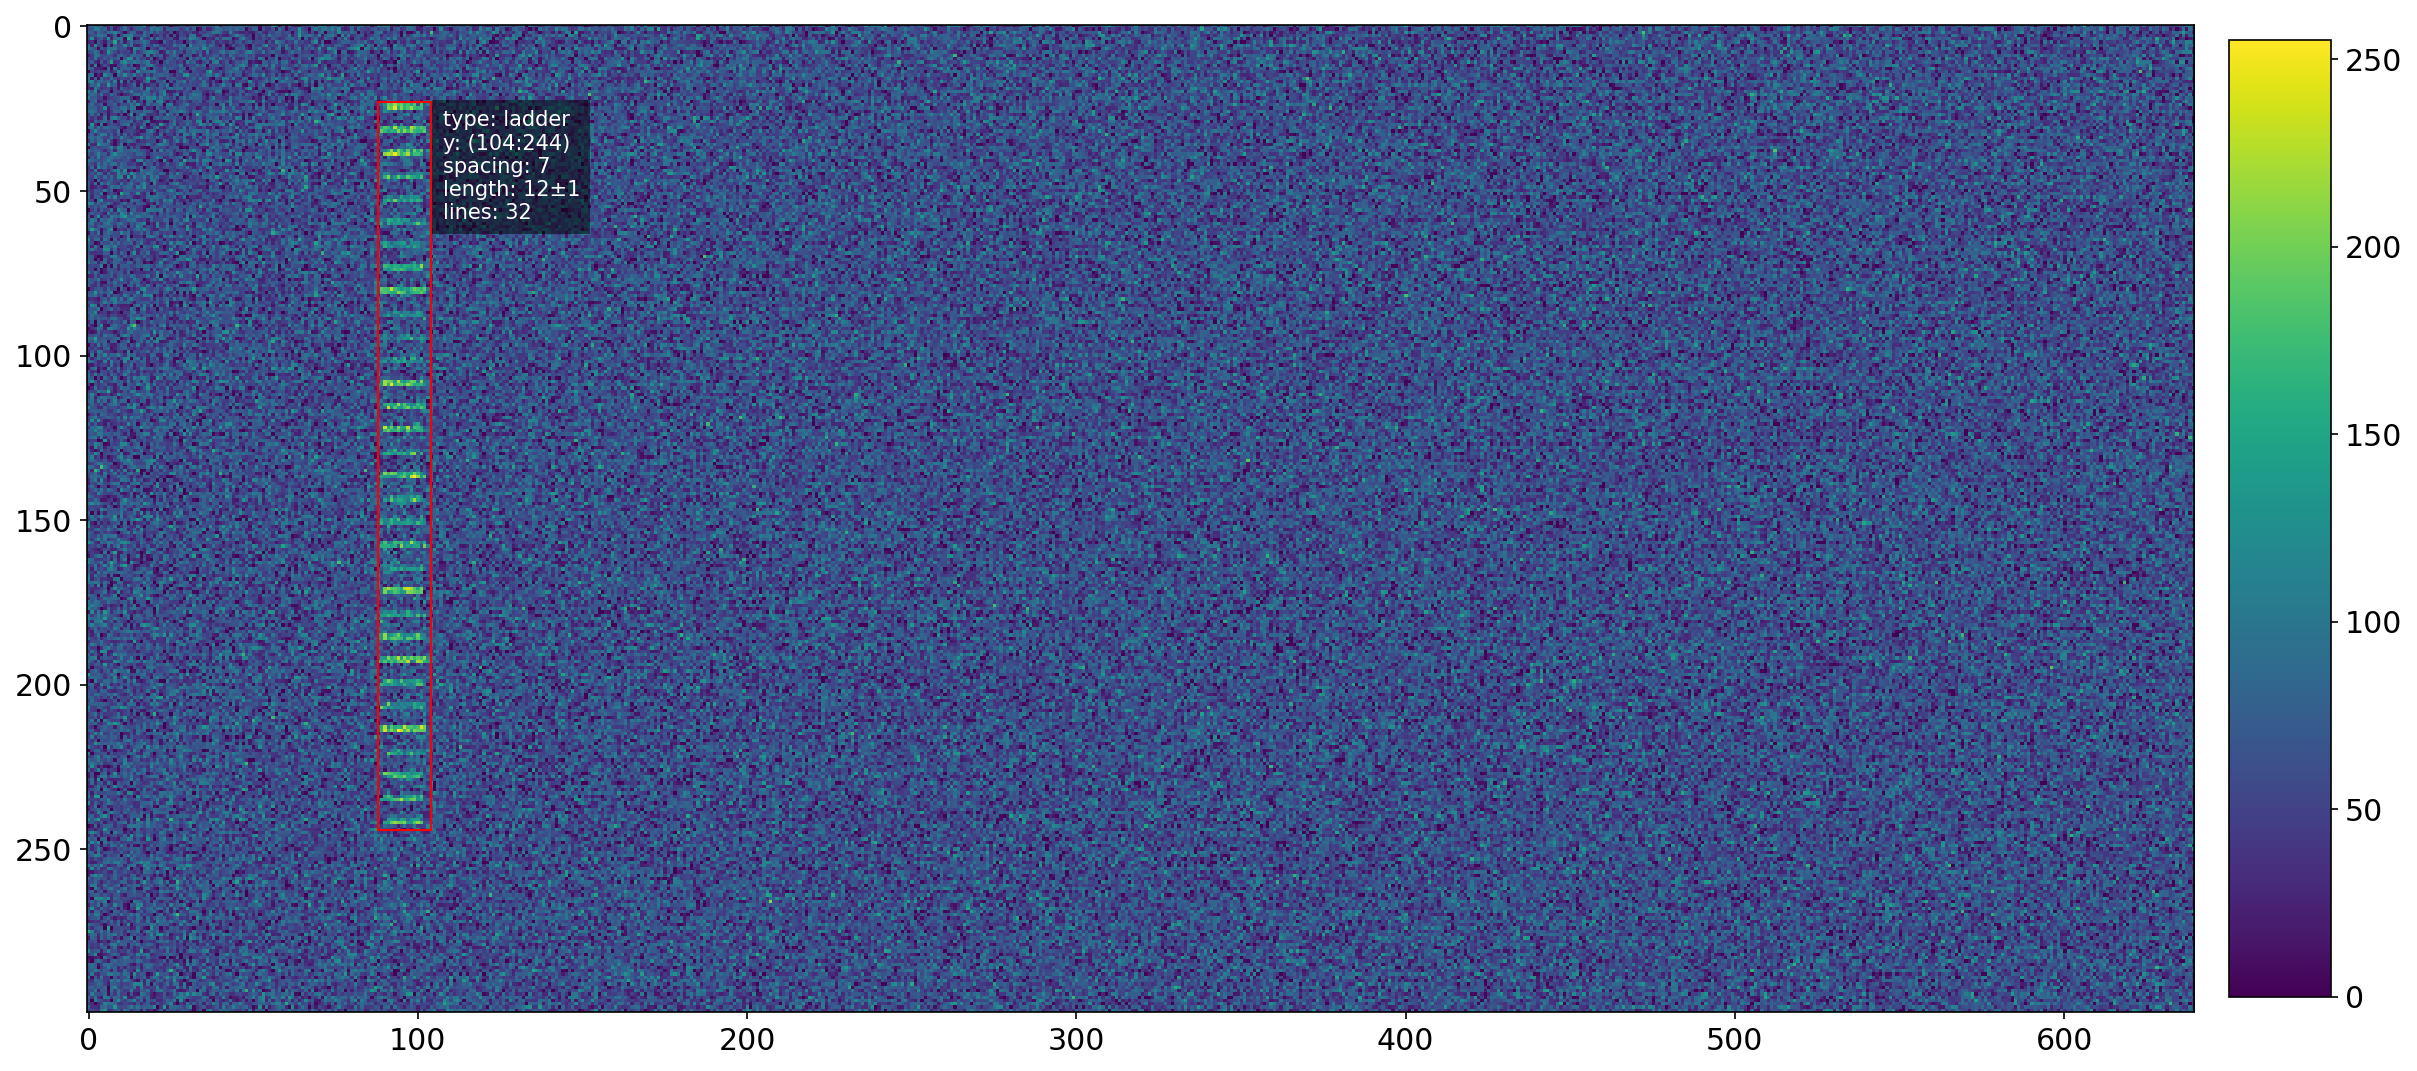

In [43]:
train.plot_label()

##Train

In [ ]:
def train_models(train, validation, classification_model, segmentation_model, batch_size=128):
    my_callbacks = [
      tf.keras.callbacks.EarlyStopping(patience=2),
      # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
      tf.keras.callbacks.ReduceLROnPlateau(),
      # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
    var_time = timing()
    # datagen_c = ds.DataGenerator(train, network='classif', batch_size=batch_size)
    # datagen_c_v = ds.DataGenerator(validation, network='classif', batch_size=batch_size)
    # print('Training classification model')
    # classification_model.fit(datagen_c, validation_data=datagen_c_v, epochs=4, callbacks=my_callbacks)
    # var_time = timing('classification training', var_time)
    datagen_s = ds.DataGenerator(train, network='segm', batch_size=batch_size)
    datagen_s_v = ds.DataGenerator(validation, network='segm', batch_size=batch_size)
    print('Training segmentation model')
    segmentation_model.fit(datagen_s, validation_data=datagen_s_v, epochs=4)
    plt.imshow(datagen_s.mask)
    #plt.imshow(datagen_s.mask)
    var_time = timing('segmentation training', var_time)
    gc.collect()

In [ ]:
height, width = (90, 640)
validation = imsy.Image(height, width, noise_lvl=0.12)
validation.add_ladder(starting_pt=[300, 15],
                spacing=7, length=12, l_var=1, lines=10)
validation.clip()

In [ ]:
validation.plot_label()

## Train

In [42]:
# del classification_model, segmentation_model
classification_model = ds.classification_model(img_shape, dropout=False, fine_tune_layers=0)
segmentation_model = ds.segmentation_model(img_shape)

In [ ]:
train.sliding_window(32,1,1,0.9)
labels = keras.utils.to_categorical(train.labels['classif'].reshape(-1), train.classes+1)
crops = train.crops.reshape(-1,32,32,1)/255
ds_train = ds.crops_to_dataset(crops, labels, split=False)
classification_model.fit(ds_train.batch(64), epochs=4)
# classification_model.fit(crops, labels, batch_size=64, epochs=4)

Epoch 1/4
2261/2560 [=========================>....] - ETA: 26s - loss: 0.1042 - accuracy: 0.9756

In [ ]:
reload(ds)
reload(imsy)

<module 'ImageSynthetique' from '/content/ImageSynthetique.py'>

In [ ]:
gc.collect()

525

In [ ]:
preprocessing_fn = sm.get_preprocessing('resnet34')
print(train.crops.shape)
crops = np.expand_dims(train.crops, axis=-1)
crops = imsy.reshape_dataset(crops)
segmentation_crops = train.labels['segm'].reshape(crops.shape)
print(segmentation_crops.shape)
segmentation_crops /= segmentation_crops.max()
#crops = np.repeat(crops, 3, axis=3)
crops = preprocessing_fn(crops)
history = segmentation_model.fit(crops, segmentation_crops, validation_split=0.3, batch_size=64, epochs=1)

#Test

In [36]:
def test_train(test, classification_model, segmentation_model, threshold=0.9):
    var_time = timing()
    print('Testing with classification model')
    y_pred = classification_model.predict(test.crops.reshape(-1,32,32,1))
    y_pred = np.reshape(y_pred, test.crops.shape[:2]+(2,))
    indexes = np.where(y_pred>threshold)[:2]
    classified_crops = np.expand_dims(test.crops[indexes], axis=-1)
    mask = np.zeros(test.crops.shape[:2])
    unsupervised_labels = np.argmax(y_pred[indexes], axis=-1)
    mask[indexes] = unsupervised_labels + 1
    plt.figure(figsize=(10,20))
    # plt.imshow(mask, aspect='auto')
    cmap = {0:[1.,1.0,1.0,1],1:[0.3,0.3,1.0,1],2:[0.5,0.1,0.3,1]}
    labels = {0:'Non détecté',1:'Fond',2:' Échelle'}
    arrayShow = np.array([[cmap[i] for i in j] for j in mask])
    ## create patches as legend
    patches_ =[patches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
    plt.imshow(arrayShow)
    plt.legend(handles=patches_, loc=4, borderaxespad=0.)
    plt.savefig('test_train_label')
    print('Total ladder classified crops: {}'.format(classified_crops.shape[0]))
    # print('Classified crops with correct label: {}'
    #           .format(np.bincount(test.labels['classif'][np.argmax(indexes,axis=1)] > 0)[1]))

    print('Updating network with new examples')
    unsupervised_labels = keras.utils.to_categorical(unsupervised_labels, y_pred.shape[-1])
    print(unsupervised_labels.shape, classified_crops.shape)
    ds_test_train = tf.data.Dataset.from_tensor_slices((classified_crops, unsupervised_labels))
    # classification_model.fit(ds_test_train.batch(16), epochs=2)
    var_time = timing('classification training', var_time)


    # print('Training segmentation model')
    # #plt.imshow(datagen_s.mask)
    # var_time = timing('segmentation training')
    # y_pred = segmentation_model.predict(test.crops.reshape(-1,32,32,1))
    # mask = np.zeros_like(y_pred)
    # mask[np.where(y_pred > threshold)] +=1
    # print(mask.shape)
    # mask = mask.reshape(300//32, 640//32, 32, 32, 1)
    # mask = mask.swapaxes(1, 2)
    # mask = mask.reshape(300//32*32, 640//32*32,1)
    # plt.imshow(mask[:,:,0])
    # plt.show()


In [41]:
test_train(train, classification_model, segmentation_model)

Testing with classification model


AttributeError: ignored

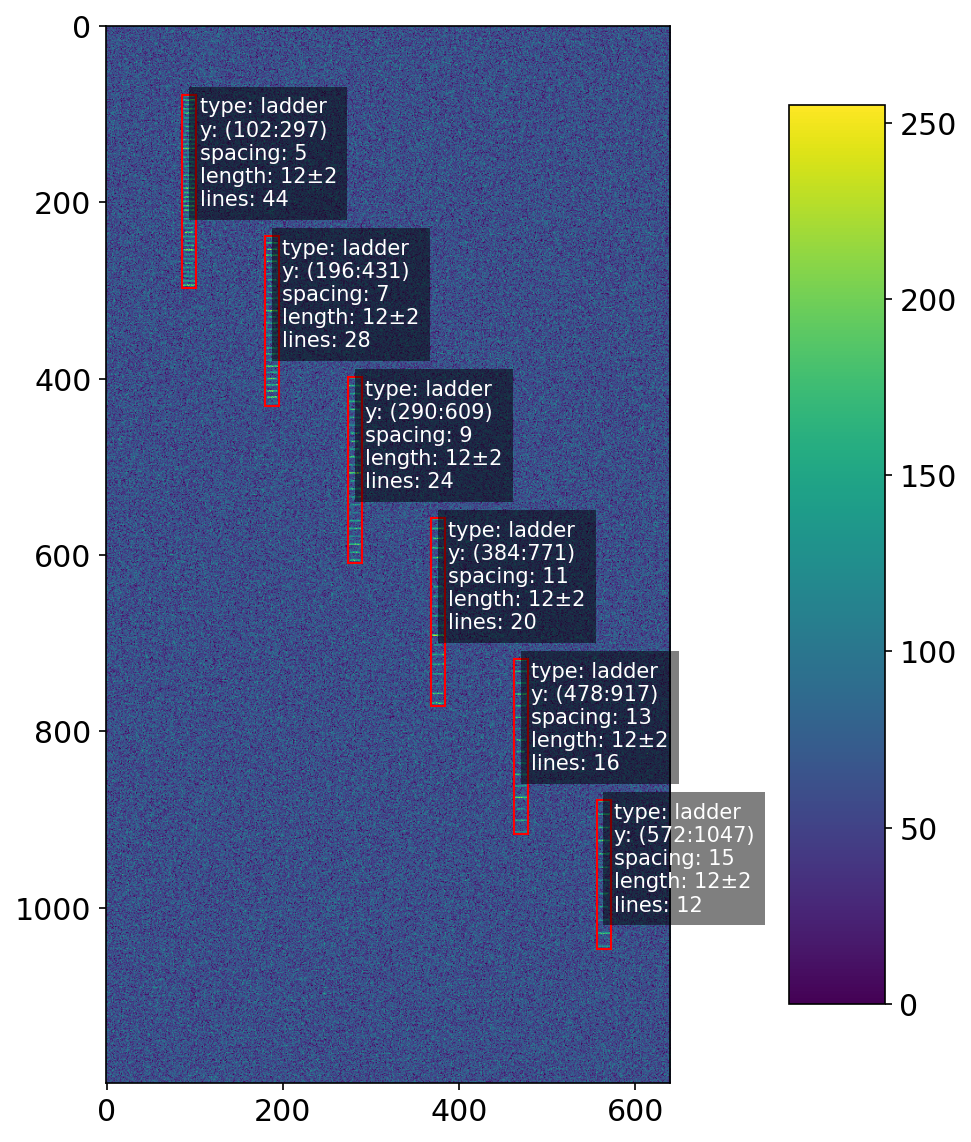

In [31]:
seed = 30
test = imsy.Image(1200, noise_lvl=0.12, seed=seed)
spacings = [5, 7, 9, 11, 13, 15]
for spacing in spacings:
    pt = [47*(spacing-3), 80*(spacing-4)]
    test.add_ladder(starting_pt=pt,
                    spacing=spacing, length=12,
                    l_var=2, lines=4*(55//spacing), seed=seed)
test.clip()
test.plot_label()

In [32]:
test.sliding_window(32,32,32,0.9)

Testing with classification model
Total ladder classified crops: 740
Updating network with new examples
(740, 2) (740, 32, 32, 1)
Part classification training took 2.06s


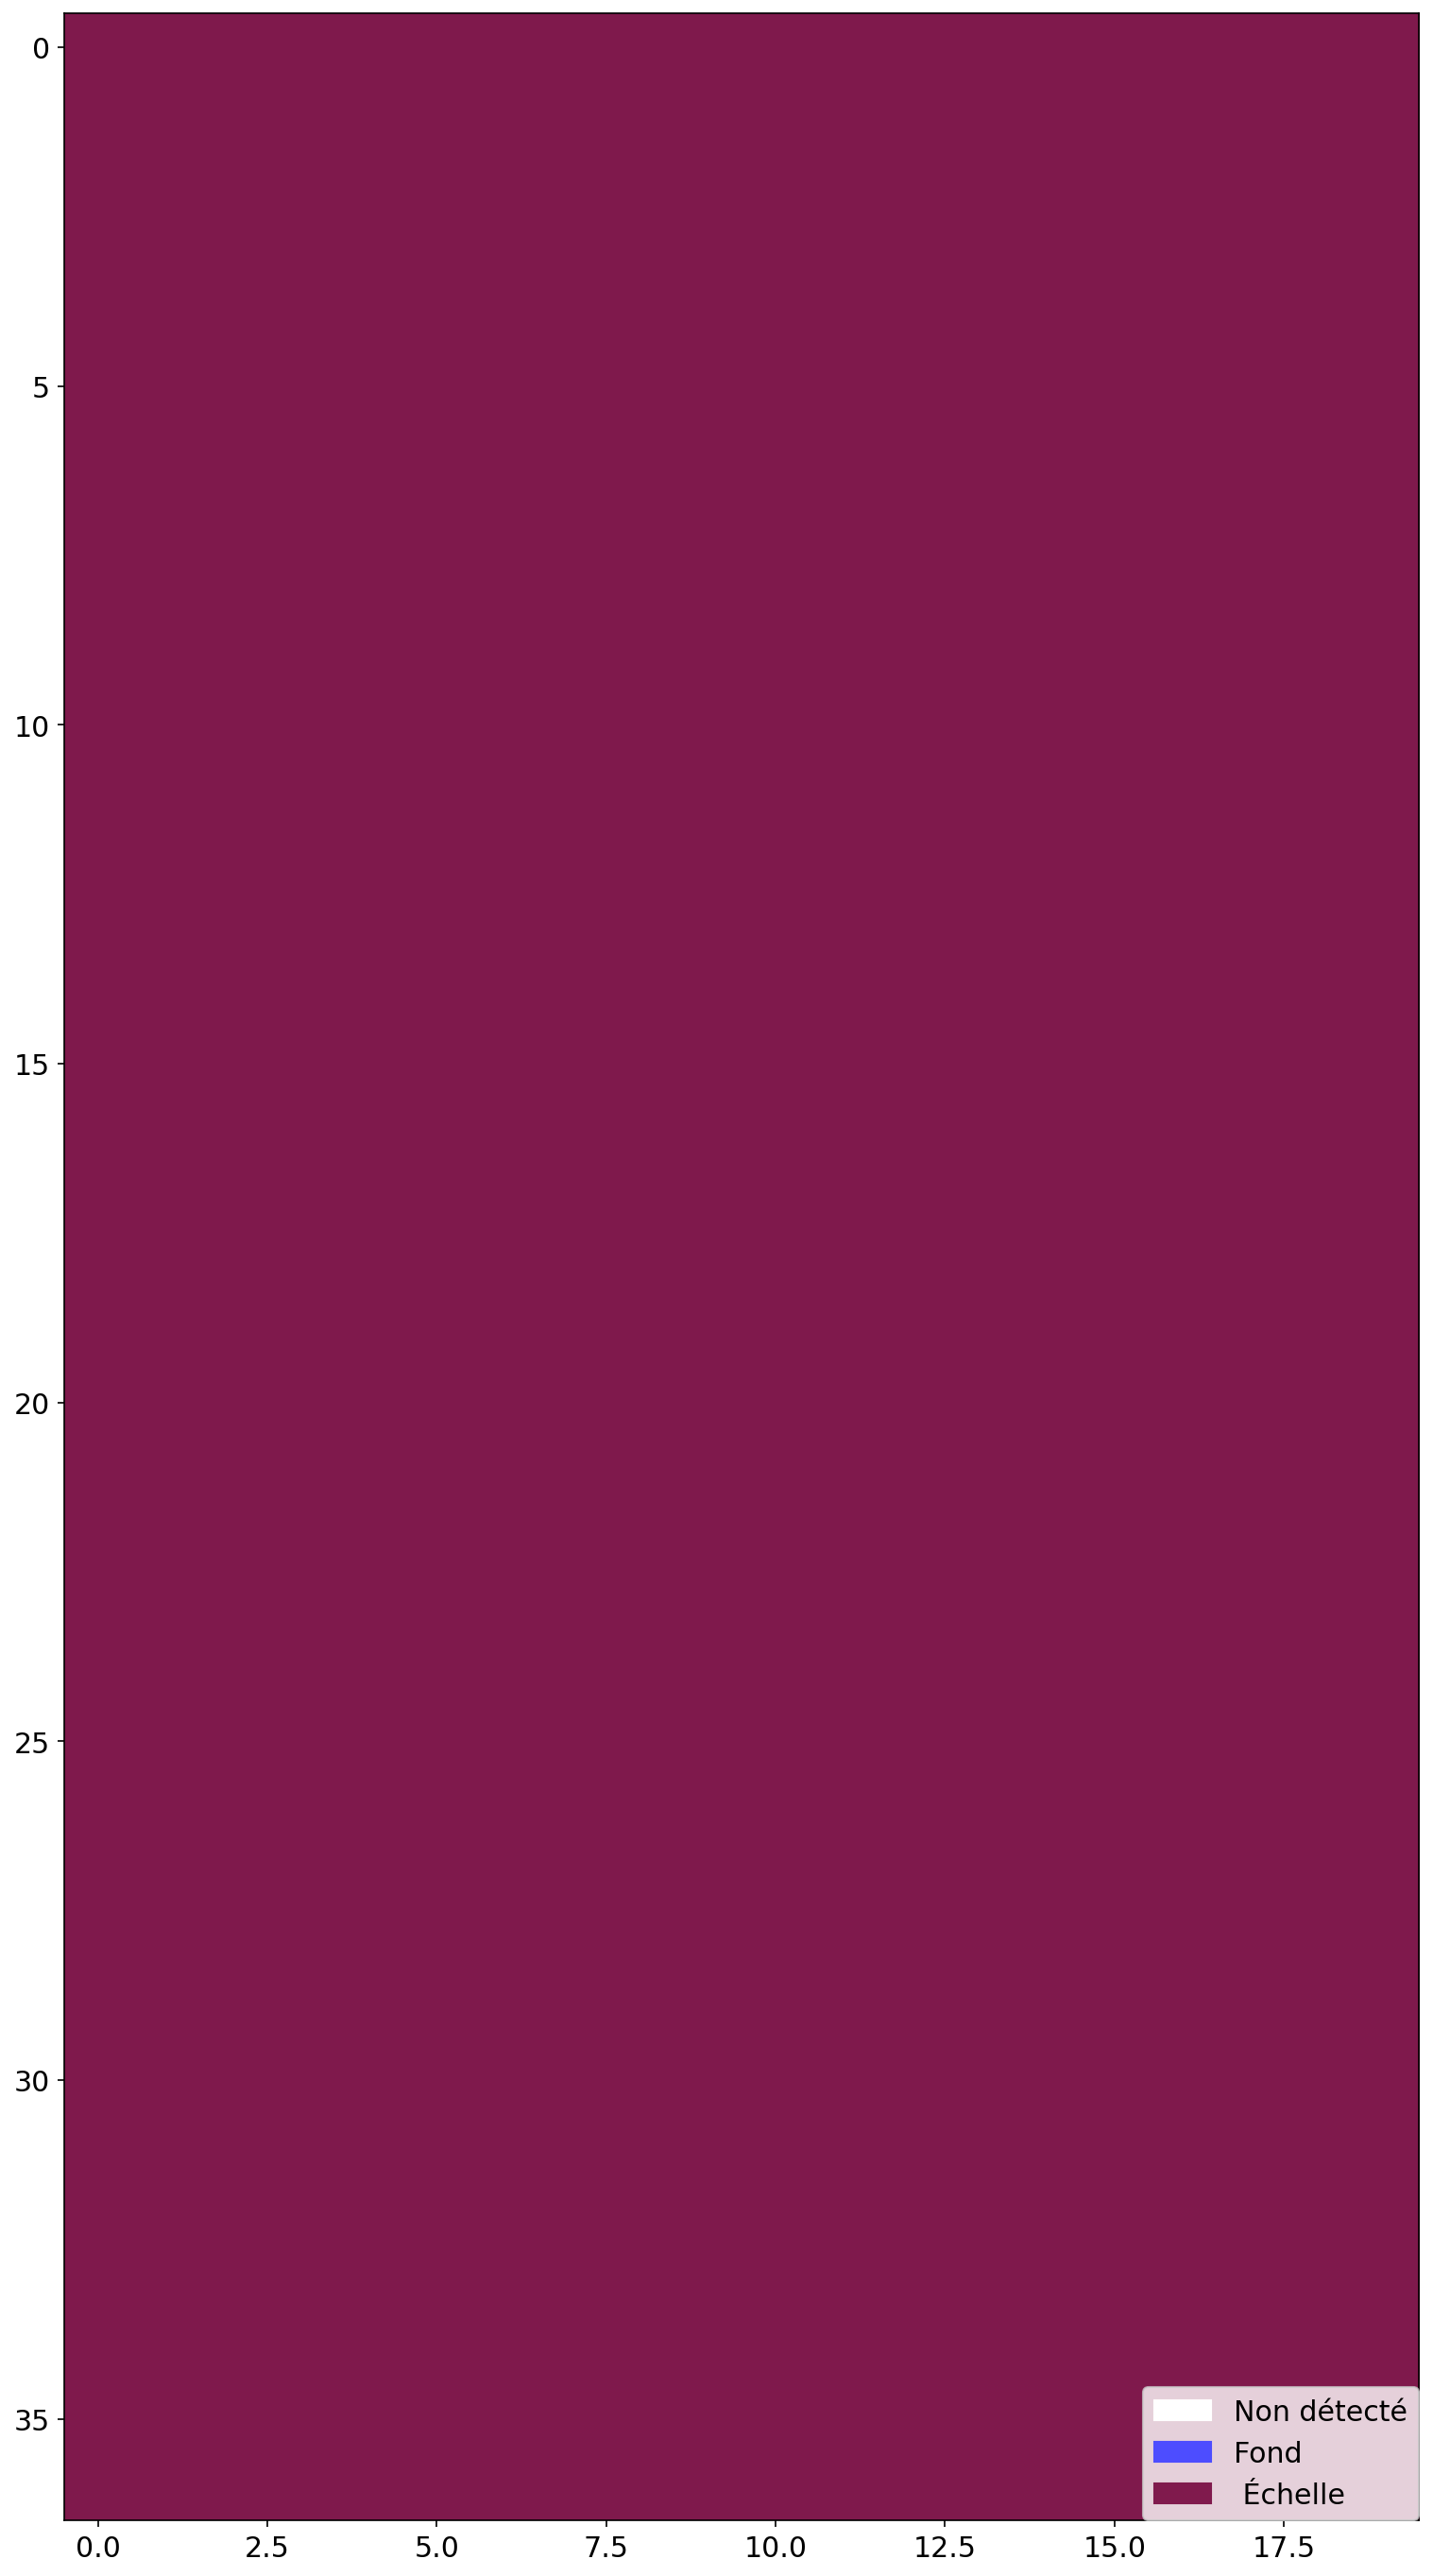

In [37]:
test_train(test, classification_model, segmentation_model, threshold=0.9999)